In [1]:
import pandas as pd
import mplfinance as mpf
from regime_detection import get_msm, identify_bull_bear_states, get_transition_counts
import numpy as np
from deeptime import markov
from utils import generate_ar_weights, indicator_signal
import random
import matplotlib.pyplot as plt
from trend import generate_signals, get_action_dates, plot_actions

In [2]:
random.seed(42)

In [3]:
symbol = 'GESHIP'
df = pd.read_csv(f'../data/symbols/{symbol}.csv')
data = df[['date', 'returns']]
data['returns'] = data['returns']
data.describe()

C:\Users\adity\AppData\Local\Temp\ipykernel_20764\2112785641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'] = data['returns']


,returns
count,183.000000
mean,0.007874
std,0.046621
min,-0.104248
25%,-0.021833
50%,0.004709
75%,0.035176
max,0.168406


In [4]:
split = 0.7
train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
test_data = test_data.reset_index(drop=True)

<Axes: >

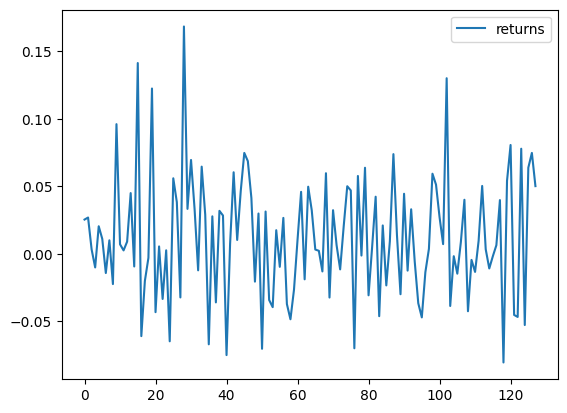

In [5]:
train_data.plot()

In [6]:
train_asset_states, train_stats = identify_bull_bear_states(train_data)

39 128


c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative returns'] = (1 + df['returns']).cumprod() - 1
c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = states
c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [7]:
train_asset_states

,date,returns,Cumulative returns,State,Turning Point
0,2022-01-03 00:00:00+05:30,0.025319,0.025319,0,True
1,2022-01-10 00:00:00+05:30,0.026819,0.052817,0,False
2,2022-01-17 00:00:00+05:30,0.003185,0.056170,0,False
3,2022-01-24 00:00:00+05:30,-0.010160,0.045439,0,False
4,2022-01-31 00:00:00+05:30,0.020369,0.066734,0,False
...,...,...,...,...,...
123,2024-05-13 00:00:00+05:30,0.077823,2.585513,0,True
124,2024-05-20 00:00:00+05:30,-0.052843,2.396043,1,True
125,2024-05-27 00:00:00+05:30,0.063790,2.612676,0,True
126,2024-06-03 00:00:00+05:30,0.074724,2.882629,0,False


In [8]:
train_stats

,State,mean,std
0,0,0.033858,0.037844
1,1,-0.026880,0.027860


In [9]:
mu_a, mu_b = train_stats.loc[0, 'mean'], train_stats.loc[1, 'mean']
sigma_a, sigma_b = train_stats.loc[0, 'std'], train_stats.loc[1, 'std']

In [10]:
test_data

,date,returns
0,2024-06-17 00:00:00+05:30,-0.039645
1,2024-06-24 00:00:00+05:30,0.049161
2,2024-07-01 00:00:00+05:30,0.034939
3,2024-07-08 00:00:00+05:30,0.135984
4,2024-07-15 00:00:00+05:30,-0.101028
5,2024-07-22 00:00:00+05:30,0.038928
6,2024-07-29 00:00:00+05:30,-0.008735
7,2024-08-05 00:00:00+05:30,-0.000412
8,2024-08-12 00:00:00+05:30,0.035414
9,2024-08-19 00:00:00+05:30,-0.045326


In [11]:
test_asset_states, test_stats = identify_bull_bear_states(test_data)

10 55


In [12]:
test_stats

,State,mean,std
0,0,0.027200,0.050641
1,1,-0.018372,0.039634


In [13]:
transition_counts, total = get_transition_counts(train_asset_states)
transition_counts

[[0.7654320987654321, 0.2345679012345679],
 [0.41304347826086957, 0.5869565217391305]]

In [14]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

true_msm = markov.msm.MarkovStateModel(transition_counts)
trajectory = true_msm.simulate(50000)
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()
counts


TransitionCountModel-2699340561760:[{'count_matrix': array([[24694.,  7356.],
                                          [ 7355., 10594.]]),
                                    'count_matrix_full': array([[24694.,  7356.],
                                          [ 7355., 10594.]]),
                                    'counting_mode': 'sliding',
                                    'lagtime': 1,
                                    'state_histogram': array([32050, 17950]),
                                    'state_histogram_full': array([32050, 17950]),
                                    'state_symbols': array([0, 1])}]

In [15]:
regime_switching_model = estimator.fit(counts).fetch_model()
print("Estimated transition matrix:", regime_switching_model.transition_matrix)
print("Estimated stationary distribution:", regime_switching_model.stationary_distribution)

Estimated transition matrix: [[0.77048362 0.22951638]
 [0.40977214 0.59022786]]
Estimated stationary distribution: [0.64098154 0.35901846]


In [16]:
alpha, beta = regime_switching_model.transition_matrix[0][1], regime_switching_model.transition_matrix[1][0]

In [17]:
ar_weights = generate_ar_weights(alpha, beta, mu_a, mu_b, sigma_a, sigma_b, p=20)

pi_a =  0.6409815392997399
pi_b =  0.35901846070026006
sigma =  0.04522868768907351
c =  0.41501112178140903
phi =  0.360711486268488
d =  2.42193636302561


In [18]:
ar_weights

[np.float64(0.6692958217497401),
 np.float64(0.1446254686982807),
 np.float64(0.031251541570236144),
 np.float64(0.006753021160842112),
 np.float64(0.0014592334492137102),
 np.float64(0.00031531994474582795),
 np.float64(6.813623112058377e-05),
 np.float64(1.4723286835090169e-05),
 np.float64(3.181496417738496e-06),
 np.float64(6.874768908229921e-07),
 np.float64(1.4855414350948855e-07),
 np.float64(3.210047326451844e-08),
 np.float64(6.936463429848701e-09),
 np.float64(1.4988727585773868e-09),
 np.float64(3.2388544524545823e-10),
 np.float64(6.99871160120445e-11),
 np.float64(1.5123237180266785e-11),
 np.float64(3.267920095053541e-12),
 np.float64(7.061518390777728e-13),
 np.float64(1.5258953870619381e-13),
 np.float64(3.297246574189642e-14)]

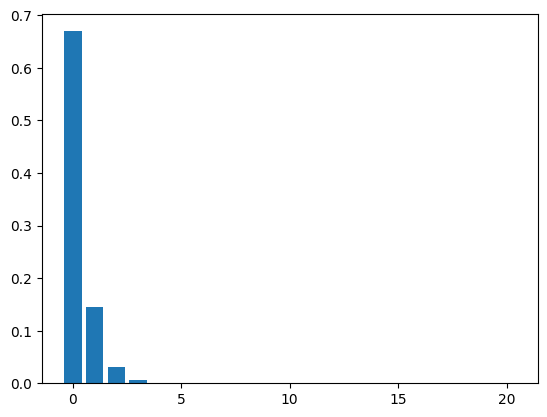

In [19]:
plt.figure()
plt.bar([i for i in range(0, len(ar_weights))], ar_weights)
plt.show()

In [20]:
len(train_data)

128

In [21]:
signals = generate_signals(train_data, ar_weights)



 this is signal 0 


0.1446254686982807 0.122440892880729 0.44270178801778526 
0.031251541570236144 -0.0030287068738477 0.4403354940484825 
0.006753021160842112 -0.0201290322580645 0.4369371995288329 
0.0014592334492137102 -0.0610613036103706 0.43470963211181174 
0.00031531994474582795 0.1413163716814158 0.4358236288745684 
6.813623112058377e-05 -0.0094507601698397 0.43580753039508846 
1.4723286835090169e-05 0.0449406039788178 0.4358240722301615 
3.181496417738496e-06 0.0089530685920578 0.43582478433405286 
6.874768908229921e-07 0.002460914881297 0.43582482662960564 
1.4855414350948855e-07 0.0069970845481048 0.4358248526157532 
3.210047326451844e-08 0.0960217287106566 0.43582492967432657 
6.936463429848701e-09 -0.0224894580665312 0.43582492577439397 
1.4988727585773868e-09 0.0099369085173501 0.435824926146748 
3.2388544524545823e-10 -0.0143034825870647 0.43582492603093076 
6.99871160120445e-11 0.0110028292989625 0.4358249260501822 
1.5123237180266785e-11 0.0203688853247796 0.43582492

In [22]:
def sma(returns, window):
    signals = []
    for i in range(len(returns)):
        if i < window:
            signals.append(0)  # Not enough data to calculate SMA
        else:
            current_sma = sum(returns[i-window:i]) / window
            prev_sma = sum(returns[i-window-1:i-1]) / window
            if current_sma > prev_sma:
                signals.append(current_sma)  # SMA rising
            elif current_sma < prev_sma:
                signals.append(current_sma)  # SMA falling
            else:
                signals.append(0)  # No change
    return signals

sma_sig = sma(np.asarray(train_data['returns'].reset_index(drop=True)), 4)

In [23]:
len(sma_sig)

128

In [24]:
len(signals), len(train_data)


(108, 128)

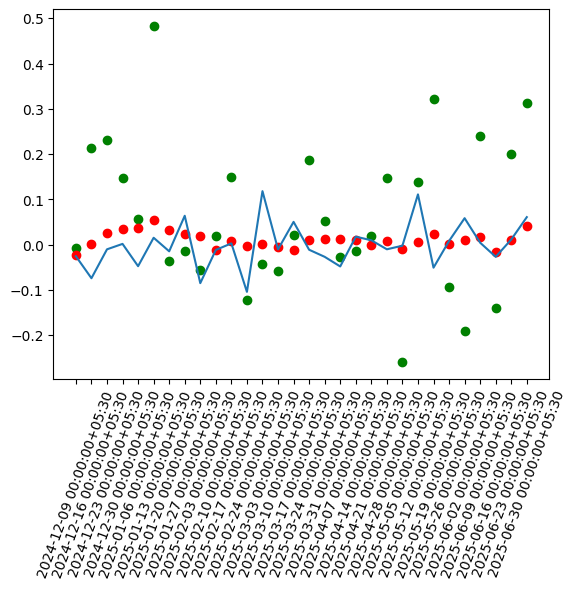

In [25]:
plt.figure()
plt.plot(data['date'][-30:], data['returns'][-30:])
plt.scatter(data['date'][-30:], signals[-30:], color='green')
plt.scatter(data['date'][-30:], sma_sig[-30:], color='red')
#plt.vlines(sell_dates[-30:], -0.05, 0.05, color='red')
plt.xticks(rotation=70)
plt.show()

In [32]:
signals

[np.float64(0.4358249260572326),
 np.float64(-0.06239696940673207),
 np.float64(0.006084908967537382),
 np.float64(-0.11988460537348047),
 np.float64(-0.016751876266023275),
 np.float64(-0.2382710170338174),
 np.float64(0.1506293030696962),
 np.float64(0.1707938195442415),
 np.float64(-0.08021571298992868),
 np.float64(0.5915625571021458),
 np.float64(0.24796884800928135),
 np.float64(0.30481674222318383),
 np.float64(0.18563928080043698),
 np.float64(-0.004395646176992245),
 np.float64(0.23240719877332336),
 np.float64(0.15457395549041086),
 np.float64(-0.20932098976957178),
 np.float64(0.05494658605355479),
 np.float64(-0.11853991310567227),
 np.float64(0.08931521536892036),
 np.float64(0.1216575114069138),
 np.float64(-0.24533154515815825),
 np.float64(-0.026985759662025616),
 np.float64(0.2124199569438718),
 np.float64(0.08278515345245009),
 np.float64(0.18577735441655333),
 np.float64(0.3102418581721628),
 np.float64(0.315173701138262),
 np.float64(0.2172981324052444),
 np.float64

In [26]:
buy_dates, sell_dates = get_action_dates(train_data, signals)


In [27]:
buy_dates

['2022-05-23 00:00:00+05:30',
 '2022-06-06 00:00:00+05:30',
 '2022-07-04 00:00:00+05:30',
 '2022-07-11 00:00:00+05:30',
 '2022-07-25 00:00:00+05:30',
 '2022-08-01 00:00:00+05:30',
 '2022-08-08 00:00:00+05:30',
 '2022-08-15 00:00:00+05:30',
 '2022-08-29 00:00:00+05:30',
 '2022-09-05 00:00:00+05:30',
 '2022-09-19 00:00:00+05:30',
 '2022-10-03 00:00:00+05:30',
 '2022-10-10 00:00:00+05:30',
 '2022-10-31 00:00:00+05:30',
 '2022-11-07 00:00:00+05:30',
 '2022-11-14 00:00:00+05:30',
 '2022-11-21 00:00:00+05:30',
 '2022-11-28 00:00:00+05:30',
 '2022-12-05 00:00:00+05:30',
 '2022-12-19 00:00:00+05:30',
 '2023-01-02 00:00:00+05:30',
 '2023-01-23 00:00:00+05:30',
 '2023-02-06 00:00:00+05:30',
 '2023-03-06 00:00:00+05:30',
 '2023-03-13 00:00:00+05:30',
 '2023-03-27 00:00:00+05:30',
 '2023-04-03 00:00:00+05:30',
 '2023-04-10 00:00:00+05:30',
 '2023-04-17 00:00:00+05:30',
 '2023-05-01 00:00:00+05:30',
 '2023-05-15 00:00:00+05:30',
 '2023-05-22 00:00:00+05:30',
 '2023-06-05 00:00:00+05:30',
 '2023-06-

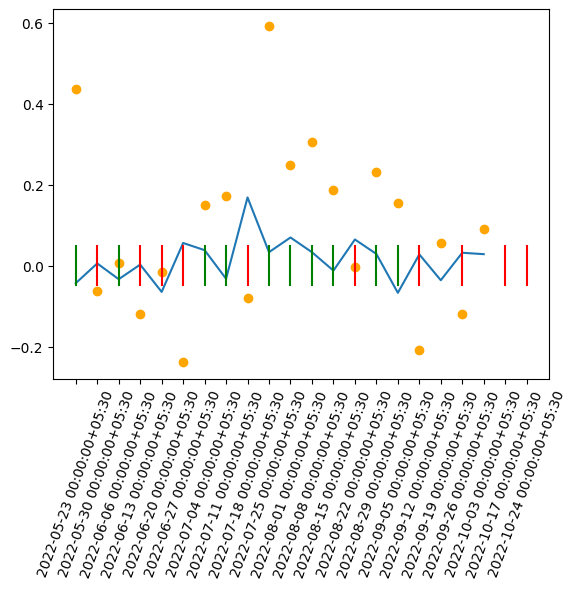

In [28]:
plot_actions(train_data, buy_dates, sell_dates, signals)

In [29]:
test_signals = generate_signals(test_data, ar_weights)



 this is signal 0 


0.1446254686982807 0.0298740877375891 0.10801384852455959 
0.031251541570236144 -0.0166791530302431 0.09498261741753528 
0.006753021160842112 -0.0029485768202547 0.09448482237599656 
0.0014592334492137102 0.0310916534922371 0.09561907189517743 
0.00031531994474582795 0.0196329668512853 0.09577383854574603 
6.813623112058377e-05 -0.0114407125929557 0.09575435036981059 
1.4723286835090169e-05 -0.0286553421177964 0.09574380284927664 
3.181496417738496e-06 -0.0269936281135354 0.09574165584599802 
6.874768908229921e-07 -0.0279289763129246 0.09574117583285303 
1.4855414350948855e-07 0.0110061102888154 0.09574121670793521 
3.210047326451844e-08 -0.0453260869565217 0.09574118033321415 
6.936463429848701e-09 0.0354141656662665 0.09574118647444077 
1.4988727585773868e-09 -0.0004124948438144 0.09574118645898384 
3.2388544524545823e-10 -0.0087354100066909 0.09574118638825203 
6.99871160120445e-11 0.0389279369738162 0.09574118645636338 
1.5123237180266785e-11 -0.1010276350506

In [30]:
test_buy_dates, test_sell_dates = get_action_dates(test_data, test_signals)

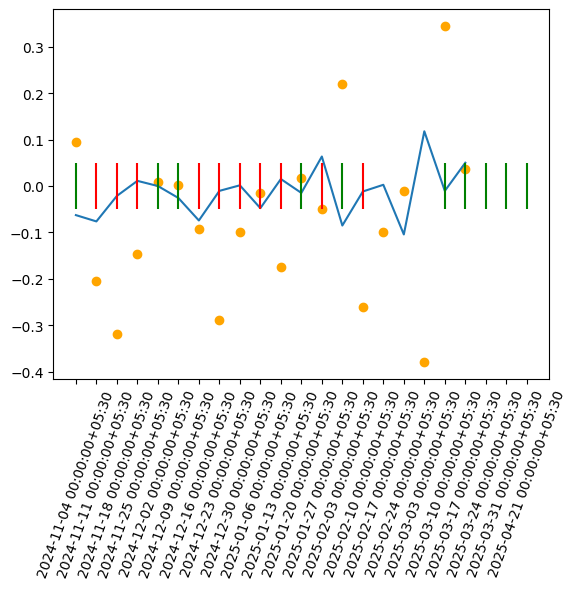

In [31]:
plot_actions(test_data, test_buy_dates, test_sell_dates, test_signals)